# Assignment 2 Stochastic Simulation - Discrete Event Simulation 

In this assignment we will use the following notation:
- $\lambda$ - the arrival rate into the system.
- $\mu$ - the capacity of eaach of $\textit{n}$ equal servers.
- $\rho$ - the system load. In a single server system, it will be 
$\rho = \frac{\lambda}{\mu}$. In a multi-server system (one queue with $\textit{n}$ equal servers, each with capacity $\mu$), it will be $\rho = \frac{\lambda}{n \mu}$

The mean waiting time for an M/M/1 queuing system is defined by:

$$
E(W) = E(s) - \frac{1}{\mu} = \frac{\frac{\rho}{\mu}}{1 - \rho}
$$

where $ p = \frac{\lambda}{\mu} $

The mean waiting time for an M/M/n queuing system is defined by:

$$
E(W) = \Pi_W \cdot \frac{1}{1 - \rho} \cdot \frac{1}{n \mu}
$$

where \( n \) is defined as the number of servers that are available and $ p = \frac{\lambda}{n \mu} $

In the case of multiple servers, the probability that all servers are full has to be taken into account. 
This is defined as:

$$
\Pi_W = \rho_n + \rho_{n+1} + \rho_{n+2} + \cdots = \frac{\rho_{c}}{1 - \rho}
$$

To see that the average waiting times are shorter for an M/M/n system, we will look at the specific case of M/M/2.

In this case, $n = 2$, so $\rho = \frac{\lambda}{2\mu}$

In an M/M/n system, the equilibrium probabilities are given by:

$P_n = \frac{(pn)^n}{n!}P_0$ for $n \leq c$

For the comparison of waiting times, we are interested in $P_2$, as waiting times occur in this scenario.
$$
\begin{array}{l}
- P_0 = P_0, \quad \text{Probability that there are no customers in the system,} \\
- P_1 = \rho P_0, \quad \text{Probability that 1 server is busy,} \\
- P_2 = \frac{\rho^2}{2} P_0, \quad \text{Probability that both servers are busy.}
\end{array}
$$

The normalization condition requires:
$$
P_0 + P_1 + P_2 = 1.
$$

Substitute these into the normalization condition:
$$
P_0 + \rho P_0 + \frac{\rho^2}{2} P_0 = 1.
$$

#### Solving for $P_0$
Factor out $P_0$:
$$
P_0 \left(1 + \rho + \frac{\rho^2}{2}\right) = 1.
$$

Solve for $P_0$:
$$
P_0 = \frac{1}{1 + \rho + \frac{\rho^2}{2}}.
$$

#### Substituting $P_0$ into $P_2$
Using the formula for $P_2$:
$$
P_2 = \frac{\rho^2}{2} P_0.
$$

Substitute $P_0 = \frac{1}{1 + \rho + \frac{\rho^2}{2}}$:
$$
P_2 = \frac{\rho^2 / 2}{1 + \rho + \frac{\rho^2}{2}}.
$$

Expand $\Pi_W$ for $M/M/2$:

$$
\Pi_W = P_2 = \frac{\rho^2 / 2}{1 + \rho + \rho^2 / 2}.
$$

Substitute $\Pi_W$ into $E(W)_{M/M/2}$:

$$
E(W)_{M/M/2} = \frac{\rho^2 / 2}{1 + \rho + \rho^2 / 2} \cdot \frac{1}{1 - \rho} \cdot \frac{1}{2\mu}.
$$

Simplifying yields:

$$
E(W)_{M/M/2} = \frac{\rho^2 / 2}{\left(1 + \rho + \frac{\rho^2}{2}\right) \cdot (1 - \rho) \cdot 4\mu},
$$


When comparing this with the waiting time for an M/M/1 system: 

$$
E(W)_{M/M/1} = \frac{\rho / \mu}{1 - \rho}
$$

The denominator of $E(W)_{M/M/2}$ is smaller than $E(W)_{M/M/1}$ because $\rho \leq 1$. And even though the nominator of $E(W)_{M/M/2}$ grows faster than the nominator of $E(W)_{M/M/1}$, the halving of the traffic intensity for $M/M/2$, yields to lower average waiting times for an $M/M/2$ queuing system, which can be generalized $to M/M/n$ systems.

### Non-mathematical explanation:

The M/M/2 system has shorter average waiting times than the M/M/1 system due to the workload being divided between two servers, leading to reduced queues and a higher overall efficiency in serving customers.

In [2]:
import numpy
import simpy
from random import seed
from scipy.stats import t
from scipy.stats import ttest_ind
import random
import statistics
import matplotlib.pyplot as plt

In [ ]:
number_of_servers = [1,2,4]

def simulate_mmn( mean_interarrival, mean_service_time, n, simulation_time, measurement_time_interval, random_seed):
    random.seed(random_seed)

    waitingTimes = []
    serviceTimes = []
    interarrivalTimes = []
    queue_lengths = []
    timestamps = []

    def generator(env, interval, server):  # customer generator with interarrival times.
        """generator generates customers randomly"""
        while True:
            c = customer(env, f'Customer_{env.now:.2f}', server, service_time=random.expovariate(1.0/mean_service_time))
            env.process(c)
            t = random.expovariate(1.0/ interval)
            interarrivalTimes.append(t)
            yield env.timeout(t)  # adds time to the counter, does not delete from the memory

    def customer(env, name, server, service_time):
        # customer arrives to the system, waits and leaves
        arrive = env.now
        #print('%7.4f : Arrival time of %s' % (arrive, name))
        with server.request() as req:
            results = yield req | env.timeout(arrive)
            
            if req in results:
                servertime = service_time
                yield env.timeout(servertime)
                serviceTimes.append(servertime)
            else:
                waiting_time = env.now - arrive
                waitingTimes.append(waiting_time)
       
    def monitor(env, server):
        while True:
            queue_lengths.append(len(server.queue))
            timestamps.append(env.now)
            yield env.timeout(measurement_time_interval)

    env = simpy.Environment()
    server = simpy.Resource(env, capacity=n)  # capacity changes the number of generators in the system.
    env.process(generator(env, mean_interarrival, server))
    env.process(monitor(env, server))
    env.run(until=simulation_time)
    #interarrivalTimes.append(interarrival)

    dimension = int(simulation_time / measurement_time_interval)
    queue_lengths_matrix = numpy.array(queue_lengths[:dimension])

    average_interarrival = statistics.mean(interarrivalTimes)
    average_waitingTime = statistics.mean(waitingTimes) if waitingTimes else 0
    average_serviceTime = statistics.mean(serviceTimes)
    return {
        "servers": n,
        "average_interarrival": average_interarrival,
        "average_waitingTime": average_waitingTime,
        "average_serviceTime": average_serviceTime,
        "queue_lengths_matrix" : queue_lengths_matrix,
        "timestamps" : timestamps
    }

def confidence_interval(data, confidence=0.95):
    n = len(data)
    mean = numpy.mean(data)
    std_err = numpy.std(data, ddof=1) / numpy.sqrt(n)
    t_value = t.ppf((1+ confidence)/2, df=n-1)
    return mean, mean - t_value * std_err, mean + t_value * std_err  

system_load = 0.95
mean_service_time = 4
simulations = 50
servers = [1,2,4]
simulation_time = 2000
measurement_time_interval = 5
random.seed(42)

service_rate = 1/mean_service_time
mean_interarrival_by_n = {n: 1 / (n*system_load * service_rate) for n in servers}

results = {1: [], 2: [], 4: []}
queue_length_matrices = {n: [] for n in servers}
time_data = {n: [] for n in servers}


for n in servers:
    mean_interarrival = mean_interarrival_by_n[n]
    #print(f"Mean interarrival times by n: {mean_interarrival_by_n}")
    for _ in range(simulations):
        random_seed = random.randint(0,10000)
        result = simulate_mmn( mean_interarrival, mean_service_time, n, simulation_time, measurement_time_interval, random.randint(0, 10000))
        results[n].append(result['average_waitingTime'])
        queue_length_matrices[n].append(result['queue_lengths_matrix'])
        time_data[n].append(result['timestamps'])
        # print(f"Server {n}, Simulation {_}, Average Waiting Time: {result['average_waitingTime']}")
        # print(f"Results[{n}]: {results[n]}")


print("\nSimulation results for n = 1,2 and 4:")
# Output results with confidence intervals
print("\nSimulation results for n=1, 2, and 4 with Confidence Intervals:")
for n in results:
    mean, ci_lower, ci_upper = confidence_interval(results[n]) 
    print(
        f"Servers: {n}, "
        f"Mean Waiting Time: {mean:.4f}, "
        f"95% CI: ({ci_lower:.4f}, {ci_upper:.4f})"
    )



Mean interarrival times by n: {1: 4.2105263157894735, 2: 2.1052631578947367, 4: 1.0526315789473684}
Mean interarrival times by n: {1: 4.2105263157894735, 2: 2.1052631578947367, 4: 1.0526315789473684}
Mean interarrival times by n: {1: 4.2105263157894735, 2: 2.1052631578947367, 4: 1.0526315789473684}

Simulation results for n = 1,2 and 4:

Simulation results for n=1, 2, and 4 with Confidence Intervals:
Servers: 1, Mean Waiting Time: 5.1408, 95% CI: (2.6993, 7.5823)
Servers: 2, Mean Waiting Time: 1.9810, 95% CI: (0.6067, 3.3553)
Servers: 4, Mean Waiting Time: 0.2421, 95% CI: (0.0470, 0.4372)


In [7]:
t_stat_1, p_value_1 = ttest_ind(results[1], results[2], equal_var=False)
print(f"T-statistic: {t_stat_1:.4f}, P-value: {p_value_1:.4f}")

if p_value_1 < 0.05:
    print("Result is statistically significant and we can reject H0 that the mean waiting time between n=1 and n=2 does not differ significantly.")
else:
    print("Result is not statistically significant and we fail to reject H0")

t_stat_2, p_value_2 = ttest_ind(results[2], results[4], equal_var=False)
print(f"T-statistic: {t_stat_2:.4f}, P-value: {p_value_2:.4f}")

if p_value_2 < 0.05:
    print("The result is statistically significant and the null hypotheses that the mean waiting time of groups n=2 and n=4 do not differ significantly, is rejected")
else:
    print("Result is not statistically significant and we cannot reject H0")

T-statistic: 2.2664, P-value: 0.0262
Result is statistically significant and we can reject H0 that the mean waiting time between n=1 and n=2 does not differ significantly.
T-statistic: 2.5174, P-value: 0.0150
The result is statistically significant and the null hypotheses that the mean waiting time of groups n=2 and n=4 do not differ significantly, is rejected


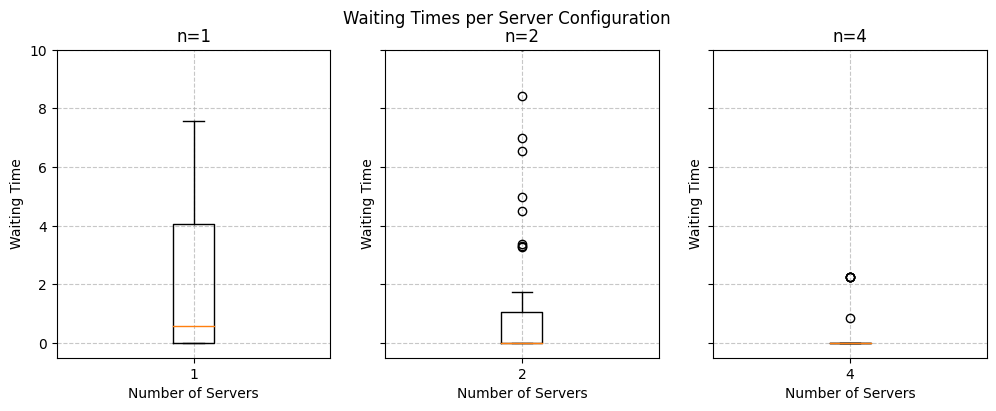

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

for i, n in enumerate([1, 2, 4]):
    axes[i].boxplot(results[n], vert=True, labels=[n])
    axes[i].set_title(f"n={n}")
    axes[i].set_xlabel("Number of Servers")
    axes[i].grid(True, linestyle='--', alpha=0.7)
    axes[i].set_ylim(-0.5,10)

    axes[i].set_ylabel("Waiting Time")
plt.suptitle("Waiting Times per Server Configuration")
plt.show()


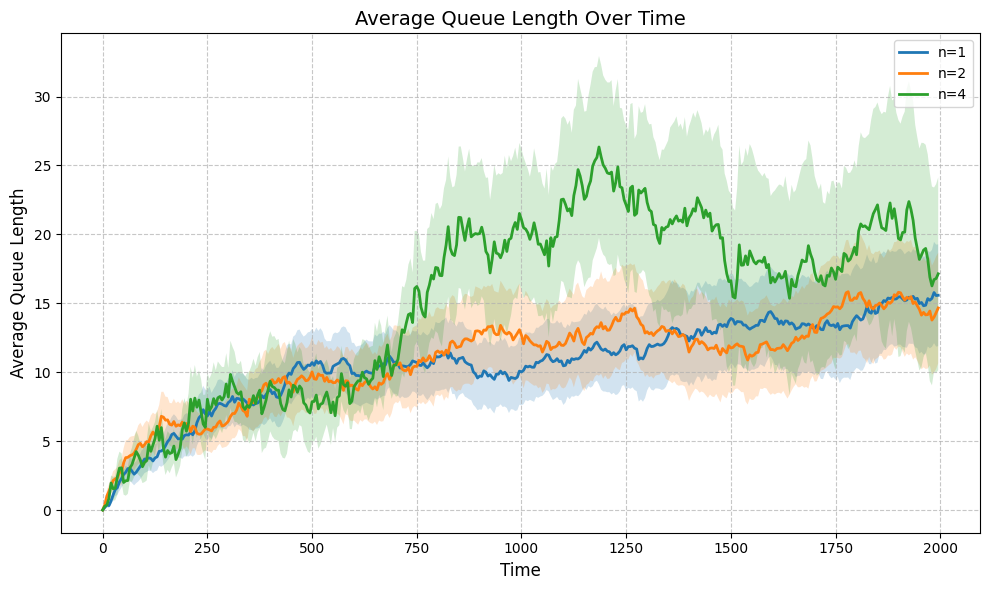

In [12]:
# Compute average queue length and confidence intervals for each time step
import numpy as np

plot_data = {}
for n, q_lengths_matrix in queue_length_matrices.items():
    q_lengths_matrix = np.array(q_lengths_matrix)
    averages = np.mean(q_lengths_matrix, axis=0)
    std_dev = np.std(q_lengths_matrix, axis=0, ddof=1)
    ci_lower = averages - 1.96 * std_dev / np.sqrt(q_lengths_matrix.shape[0])
    ci_upper = averages + 1.96 * std_dev / np.sqrt(q_lengths_matrix.shape[0])

    time_steps = np.arange(q_lengths_matrix.shape[1]) * measurement_time_interval 


    plot_data[n] = {
            "time_steps": time_steps,
            "averages": averages,
            "ci_lower": ci_lower,
            "ci_upper": ci_upper
        }


plt.figure(figsize=(10, 6))
for n in plot_data:
    time_steps = plot_data[n]["time_steps"]
    averages = plot_data[n]["averages"]
    ci_lower = plot_data[n]["ci_lower"]
    ci_upper = plot_data[n]["ci_upper"]

    # Plot averages and confidence intervals
    plt.plot(time_steps, averages, label=f'n={n}', linewidth=2)
    plt.fill_between(time_steps, ci_lower, ci_upper, alpha=0.2)

# Add plot details
plt.title("Average Queue Length Over Time", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Average Queue Length", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
